# Dog-breed clasification

In order to evaluate this code, make sure that you've downloaded the required dog dataset:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/data/dog_images`. 

In [1]:
import numpy as np
from glob import glob

# Load filenames for dog images
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# Print number of images in the dog dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


# Create a CNN to Classify Dog Breeds (from Scratch)

In this section, I'm creating a CNN that classifies dog breeds from scratch. However, the task of assigning breed to dogs from images is very challenging. To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel (source: "Udacity Deep Learning Nanodegree")

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

## Specifying Data Loaders for the Dog Dataset

First, I'm writing three separate data loaders for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).

Most of the models like VGG16 take 224x224 input size, I use RandomResizedCrop to crop randomly the images to fit this size in case of the training dataset and only resize them for test and validation. That's a common technique.I also normalize the data which might enhance the performance of my CNN.

I use data augmentation since I want my CNN to be rotation-invariant. By that, I am extending my dataset and also this might help to avoid overfitting.

In [2]:
import os
from torchvision import datasets, transforms
import torch

# Specify dirs where train, test and validation data are available
train_dir = '/data/dog_images/train/'
test_dir = '/data/dog_images/test/'
valid_dir = '/data/dog_images/test/'

# Specify batch sieze
batch_size = 20
# Specify the percentage of training set to use as validation
valid_size = 0.1

# Create data transform for test and validation data (using torchvision.transforms)
data_transform= transforms.Compose([transforms.Resize((224,224)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create data transform for train data (using torchvision.transforms)
data_transform_train= transforms.Compose([transforms.RandomRotation(15),
                                     transforms.RandomResizedCrop(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Define train, test and valid datasets using torchvision.datasets 
train_data = datasets.ImageFolder(train_dir, transform=data_transform_train)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)

# Define train, test and valid loaders using  torch.utils.data.DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Store all dog breeds (classes)
classes = train_data.classes

print('Number of training images: ', len(train_data))
print('Number of test images: ', len(test_data))
print('Number of dog breeds classes: ', len(classes))

Number of training images:  6680
Number of test images:  836
Number of dog breeds classes:  133


## Show sample images from the training dataset

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define a helper function to display an image
def imshow(image):
    img = image / 2 + 0.5  # unnormalize (opposite to applying transforms.Normalize)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

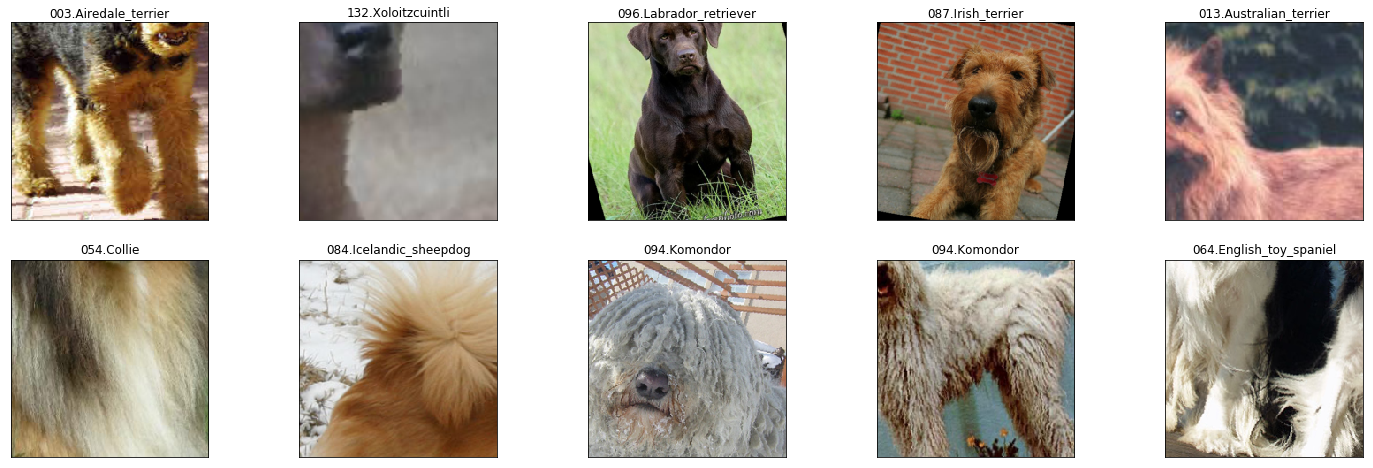

In [4]:
# Obtain one batch of training images in order to display some sample data
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Convert images to numpy to plot them later
images = images.numpy() 

# Plot the first 10 images in the batch together with the corresponding labels
fig = plt.figure(figsize=(25, 8))

# Display 10 images
for i in np.arange(10):
    ax = fig.add_subplot(2, 10/2, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

## Define and Implement Model Architecture

In my CNN architecture there are 4 convolutional layer, 4 maxpooling layers and 2 fully connected layer. I chose 4 convolutional layers to extract also the high-level features from the image (less layers could be not enough). I pass the input through each of the conv layers and maxpooling layers at first (conv1 -> maxpooling -> conv2 -> maxpooling -> conv3 -> maxpooling -> conv4 -> maxpooling) applying relu activation function between the conv and maxpooling operations. The Max Pooling Layer reduces dimensionality and helps to prevent overfitting. The convolutional layers increase the depth of the tensor including more features of the input image. The output volume of the convolutional layer is obtained by stacking the activation maps of all filters along the depth dimension. After passing the input through all those layers, we have the size of our tensor 14*14*128=25088 which is the result of applying 4 times the maxpooling layer with kernel size 2 to the input being 224x224 (224/(2^4)=14). Hence, this must be flattened in order to fit the fully connected layer. Therefore, the first fc layer has input size of 25088 and I choose 1000 output features. The second fc layer takes 1000 and returns 133 features which corresponds to the number of classes we want to detect. I also use dropout of 0.2 to avoid overfitting. After applying fc1 I also apply the relu activation function.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # First, it sees a 224x224x3 image tensor, we create 16 filters 3x3
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # We add another convolutional layer
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # We add another convolutional layer
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # We add another convolutional layer
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # Define max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Define two fully connected layers as well as a dropout of 0.2
        self.fc1 = nn.Linear(25088, 1000)
        self.fc2 = nn.Linear(1000, 133)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # Flatten x to a vector
        x = x.view(-1,25088)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the CNN
model = Net()

# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

# Print the model
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=133, bias=True)
  (dropout): Dropout(p=0.2)
)


In [6]:
import torch.optim as optim

# Specify the loss function
criterion = nn.CrossEntropyLoss()

# Select learning rate and optimizer 
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr)

### Train and Validate the Model

In the code cell below, I'm training and validating my model and finally saving the final model parameters at 'model_scratch.pt'.

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    
    # Initialize a variable-tracker for min validation loss (set as infinity)
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # For each epoch, initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # Put the model in train mode
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            #  If GPU available, move data and targets to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # Clear the gradients of all optimized variables
            optimizer.zero_grad() 
            
            # Compute the loss
            out = model(data)
            loss = criterion(out, target)
            
            # Update the model parameters according to the loss
            loss.backward()
            optimizer.step()
            
            # Record the average training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        # Put the model in eval mode
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # If GPU available, move data and targets to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Compute predicted outputs by passing inputs to the model (forward pass)
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update average validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # Print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## If validation loss has decreased, save it
        if valid_loss <= valid_loss_min:
            print('Validation loss has decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt')
            # Specify the new minimal validation loss
            valid_loss_min = valid_loss
    
    # Return trained model
    return model


# train the model
model = train(100, train_loader, valid_loader, model, optimizer, 
                      criterion, use_cuda, 'model_scratch.pt')


Epoch: 1 	Training Loss: 4.889191 	Validation Loss: 4.884231
Validation loss has decreased (inf --> 4.884231).  Saving model ...
Epoch: 2 	Training Loss: 4.880016 	Validation Loss: 4.867616
Validation loss has decreased (4.884231 --> 4.867616).  Saving model ...
Epoch: 3 	Training Loss: 4.867213 	Validation Loss: 4.852433
Validation loss has decreased (4.867616 --> 4.852433).  Saving model ...
Epoch: 4 	Training Loss: 4.847862 	Validation Loss: 4.807947
Validation loss has decreased (4.852433 --> 4.807947).  Saving model ...
Epoch: 5 	Training Loss: 4.790539 	Validation Loss: 4.734613
Validation loss has decreased (4.807947 --> 4.734613).  Saving model ...
Epoch: 6 	Training Loss: 4.736189 	Validation Loss: 4.679481
Validation loss has decreased (4.734613 --> 4.679481).  Saving model ...
Epoch: 7 	Training Loss: 4.699474 	Validation Loss: 4.646481
Validation loss has decreased (4.679481 --> 4.646481).  Saving model ...
Epoch: 8 	Training Loss: 4.639240 	Validation Loss: 4.557907
Valida

KeyboardInterrupt: 

In [8]:
# Load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_scratch.pt'))

### Testing the Model

In the code cell below, I'm trying out my model on the test dataset of dog images.

In [9]:
def test(test_loader, model, criterion, use_cuda):

    # Define variables to monitor test loss and accuracy
    test_loss = 0.0
    correct = 0.0
    total = 0.0

    # Put the model in eval mode
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # If GPU available, move data and targets to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # Compute predicted outputs by passing inputs to the model (forward pass)
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average test loss 
        test_loss += ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # Convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # Compare predictions with true labels
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    return test_loss, correct, total

test_loss, correct, total = test(test_loader, model, criterion, use_cuda)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

Test Loss: 3.988655


Test Accuracy: 12% (102/836)


## Create a CNN to Classify Dog Breeds using Transfer Learning

## Define and Implement Model Architecture

Using transfer learning, I'm creating a CNN to classify dog breed. The model will be then saved as the variable `model_transfer`.

ResNet50 is a deep residual network and a very good architecture with 50 layers perfectly suitable for image classification problems. The only adjustment I make to this pre-trained model is changing the number of output features for the last (fc) Linear layer which previously was 1000 (for detecting 1000 classes) to 133 which is the number of classes we are interested in detecting.

In [10]:
import torchvision.models as models
import torch.nn as nn
import numpy as np

# Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

# Pint out the model structure
print(model_transfer)

# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False
    
# Find the number of in_features of the fully connected layer 
n_inp = model_transfer.fc.in_features
# Create a new fc linear layer with desired number of outputs
model_transfer.fc = nn.Linear(n_inp, len(classes))

# If GPU available, move model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 93725592.03it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [11]:
import torch.optim as optim

# Specify the loss function
criterion_transfer = nn.CrossEntropyLoss()

# Select learning rate and optimizer 
lr = 0.001
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr)

### Train and Validate the Model

In the code cell below, I'm training and validating my model and finally saving the final model parameters at 'model_transfer.pt'.

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # Initialize a variable-tracker for min validation loss (set as infinity)
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # For each epoch, initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # Put the model in train mode
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # If GPU available, move data and targets to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Compute the loss
            output = model(data)
            loss = criterion(output, target)
            # Update the model parameters according to the loss
            loss.backward()
            # Update average validation loss 
            optimizer.step()
            
            # Record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        # Put the model in eval mode
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # If GPU available, move data and targets to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Compute predicted outputs by passing inputs to the model (forward pass)
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # If validation loss has decreased, save it
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss
            
    # Return trained model
    return model

n_epochs = 30

# train the model
model_transfer = train(n_epochs, train_loader, valid_loader, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.821265 	Validation Loss: 4.673786
Validation loss decreased (inf --> 4.673786).  Saving model ...
Epoch: 2 	Training Loss: 4.608478 	Validation Loss: 4.455509
Validation loss decreased (4.673786 --> 4.455509).  Saving model ...
Epoch: 3 	Training Loss: 4.416060 	Validation Loss: 4.259300
Validation loss decreased (4.455509 --> 4.259300).  Saving model ...
Epoch: 4 	Training Loss: 4.246413 	Validation Loss: 4.048548
Validation loss decreased (4.259300 --> 4.048548).  Saving model ...
Epoch: 5 	Training Loss: 4.077122 	Validation Loss: 3.890228
Validation loss decreased (4.048548 --> 3.890228).  Saving model ...
Epoch: 6 	Training Loss: 3.916089 	Validation Loss: 3.693262
Validation loss decreased (3.890228 --> 3.693262).  Saving model ...
Epoch: 7 	Training Loss: 3.766980 	Validation Loss: 3.530709
Validation loss decreased (3.693262 --> 3.530709).  Saving model ...
Epoch: 8 	Training Loss: 3.620440 	Validation Loss: 3.392622
Validation loss decreased (3.53070

In [14]:
# Load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Testing the Model

In the code cell below, I'm trying out my model on the test dataset of dog images.

In [16]:
def test(test_loader, model, criterion, use_cuda):

    # Define variables to monitor test loss and accuracy
    test_loss = 0.0
    correct = 0.0
    total = 0.0

    # Put the model in eval mode
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # If GPU available, move data and targets to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # Compute predicted outputs by passing inputs to the model (forward pass)
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # Convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # Compare predictions with true labels
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    return test_loss, correct, total


test_loss, correct, total = test(test_loader, model_transfer, criterion_transfer, use_cuda)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

Test Loss: 1.353994


Test Accuracy: 77% (649/836)


### Predicting Dog Breed with the Model

In the cell code below, I'm implementing a function that takes an image path as input and returns the dog breed  that is predicted by my model (using Transfer Learning).  

In [17]:
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True

# Define dog breeds (get rid of '_' in the breeds' names)
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    global model_transfer
    # Load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    image = data_transform(image).unsqueeze_(0)
    # If GPU available, move the image and model to GPU
    if use_cuda:
        image = image.cuda()
        model_transfer = model_transfer.cuda()
    # Put the model in eval mode
    model_transfer.eval()
    # Convert output probabilities to predicted class
    idx = torch.argmax(model_transfer(image))
    # Return obtained dog breed
    return class_names[idx]

In [18]:
def predict_and_show(file):
    img = Image.open(file)
    plt.imshow(img)
    plt.show()
    print(predict_breed_transfer(file))

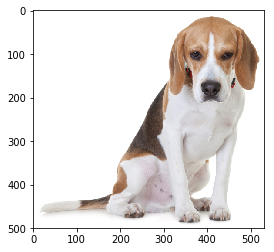

Beagle


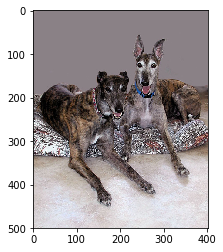

Greyhound


In [19]:
predict_and_show('/data/dog_images/train/016.Beagle/Beagle_01182.jpg')
predict_and_show('/data/dog_images/train/081.Greyhound/Greyhound_05562.jpg')

### Testing the model on my own dog images

In order to test the model on your own images, move them to `images/` and call the predict_and_show() function for them, e.g. predict_and_show('images/dog1.jpg').

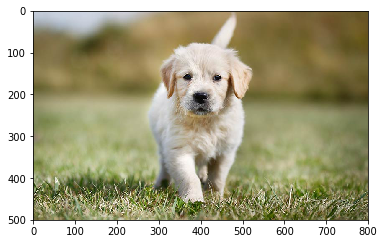

Golden retriever


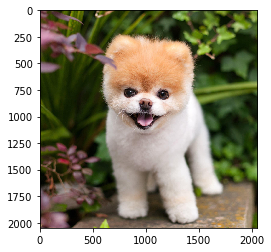

Pomeranian


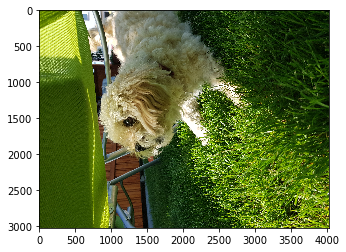

Chow chow


In [20]:
dog_files = ['images/dog1.jpg', 'images/dog2.jpg', 'images/dog3.jpg']

for file in dog_files:
    predict_and_show(file)